<a href="https://colab.research.google.com/github/EBUSYGIN/ML-3/blob/main/ML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:

# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error



train_data = pd.read_excel('train.xlsx')
test_data = pd.read_excel('test.xlsx')


train_data

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [180]:
test_data

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000
3,2022-09-26,45500
4,2022-10-03,45500
5,2022-10-10,45000
6,2022-10-17,44000
7,2022-10-24,43000
8,2022-10-31,42000
9,2022-11-07,41500


In [181]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [182]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                28 non-null     datetime64[ns]
 1   Цена на арматуру  28 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 580.0 bytes


In [183]:
train_data['dt'] = pd.to_datetime(train_data['dt'])
test_data['dt'] = pd.to_datetime(test_data['dt'])

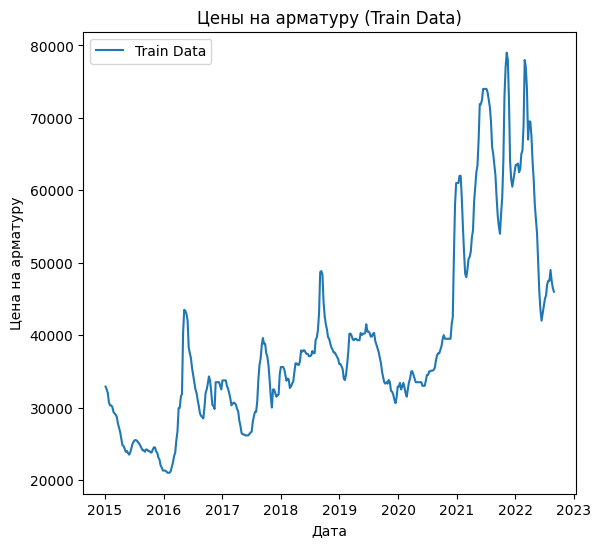

In [184]:
# Визуализация временных рядов
plt.figure(figsize=(14, 6))

# График для train данных
plt.subplot(1, 2, 1)
plt.plot(train_data['dt'], train_data['Цена на арматуру'], label='Train Data')
plt.title('Цены на арматуру (Train Data)')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.legend()

In [185]:
print(train_data['Цена на арматуру'].describe())

count      400.000000
mean     39229.475000
std      13407.979668
min      21000.000000
25%      31075.000000
50%      35450.000000
75%      42000.000000
max      79000.000000
Name: Цена на арматуру, dtype: float64


In [186]:
# Проверка сезонности для train данных
# Убедимся, что данные отсортированы по дате
train_data = train_data.sort_values('dt')

# Установим дату в качестве индекса
train_data.set_index('dt', inplace=True)


In [187]:
# Декомпозиция временного ряда
# Период сезонности можно задать вручную. Например, для недельных данных период может быть 52 (недели в году).
decomposition = seasonal_decompose(train_data['Цена на арматуру'], model='additive', period=52)

Text(0, 0.5, 'Цена на арматуру')

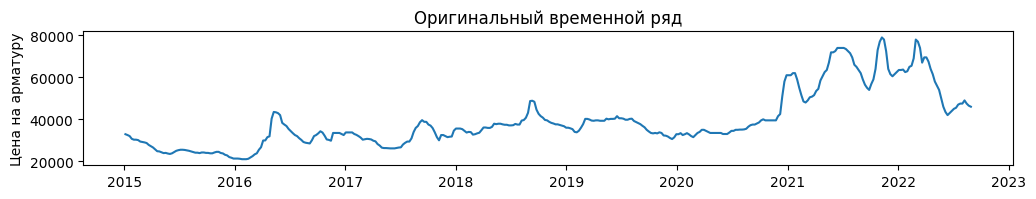

In [188]:
# Визуализация результатов декомпозиции
plt.figure(figsize=(12, 8))

# Оригинальный ряд
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Оригинальный временной ряд')
plt.ylabel('Цена на арматуру')

Text(0, 0.5, 'Тренд')

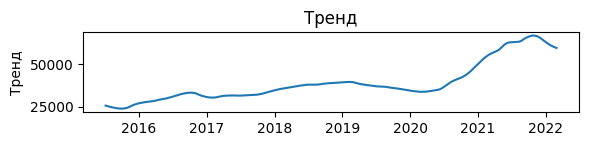

In [189]:
# Тренд
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Тренд')
plt.ylabel('Тренд')

Text(0, 0.5, 'Сезонность')

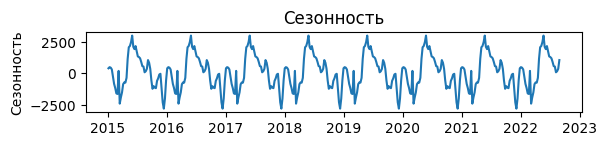

In [190]:
# Сезонность
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Сезонность')
plt.ylabel('Сезонность')

Text(0, 0.5, 'Остатки')

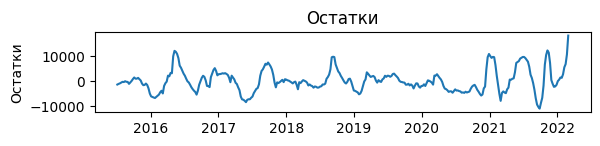

In [191]:
# Остатки
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Остатки')
plt.ylabel('Остатки')

In [192]:

# Проверка на сезонность: сравнение амплитуды сезонной компоненты со всей серией
seasonality_present = np.std(decomposition.seasonal) > 0.05 * np.std(train_data['Цена на арматуру'])

if seasonality_present:
    print("Данные имеют сезонность")
else:
    print("Данные не имеют сезонности")

# Проверка стационарности с помощью теста Дики-Фуллера
adf_test = adfuller(train_data['Цена на арматуру'].dropna())
print("\nРезультаты теста Дики-Фуллера:")
print(f"ADF-статистика: {adf_test[0]}")
print(f"p-значение: {adf_test[1]}")
print(f"Критические значения: {adf_test[4]}")

# Интерпретация теста ADF
if adf_test[1] < 0.05:
    print("Ряд является стационарным (на уровне значимости 5%)")
else:
    print("Ряд не является стационарным (на уровне значимости 5%)")

Данные имеют сезонность

Результаты теста Дики-Фуллера:
ADF-статистика: -1.9258699893713456
p-значение: 0.31999061025699155
Критические значения: {'1%': np.float64(-3.4470566389664703), '5%': np.float64(-2.8689037160476016), '10%': np.float64(-2.570692663557422)}
Ряд не является стационарным (на уровне значимости 5%)


In [193]:
train_data['diff_1'] = train_data['Цена на арматуру'].diff()

# Проверка стационарности после первого дифференцирования
adf_test_diff1 = adfuller(train_data['diff_1'].dropna())

print("\nТест Дики-Фуллера после первого дифференцирования:")
print(f"ADF-статистика: {adf_test_diff1[0]}")
print(f"p-значение: {adf_test_diff1[1]}")
print(f"Критические значения: {adf_test_diff1[4]}")

if adf_test_diff1[1] < 0.05:
    print("Ряд стал стационарным после первого дифференцирования.")
else:
    print("Ряд все еще не стационарен, попробуем второе дифференцирование.")


Тест Дики-Фуллера после первого дифференцирования:
ADF-статистика: -7.706061504115209
p-значение: 1.300693837380985e-11
Критические значения: {'1%': np.float64(-3.447405233596701), '5%': np.float64(-2.8690569369014605), '10%': np.float64(-2.5707743450830893)}
Ряд стал стационарным после первого дифференцирования.


In [194]:
train_data = train_data.reset_index()

# Количество лагов (сколько предыдущих недель учитывать)
num_lags = 10

# Добавляем лаговые переменные
for lag in range(1, num_lags + 1):
    train_data[f'lag_{lag}'] = train_data['Цена на арматуру'].shift(lag)

# Добавляем скользящее среднее (по 4 и 8 неделям)
train_data['rolling_mean_4'] = train_data['Цена на арматуру'].rolling(window=4).mean()
train_data['rolling_mean_8'] = train_data['Цена на арматуру'].rolling(window=8).mean()

# Добавляем временные признаки
train_data['year'] = train_data['dt'].dt.year
train_data['month'] = train_data['dt'].dt.month
train_data['week'] = train_data['dt'].dt.isocalendar().week

# Убираем пропущенные значения (из-за лагов)
train_data = train_data.dropna()

train_data.head()

,dt,Цена на арматуру,diff_1,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean_4,rolling_mean_8,year,month,week
10,2015-03-16,28700,-300.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0,32000.0,32500.0,32900.0,29075.0,29712.5,2015,3,12
11,2015-03-23,27800,-900.0,28700.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0,32000.0,32500.0,28675.0,29350.0,2015,3,13
12,2015-03-30,27200,-600.0,27800.0,28700.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0,32000.0,28175.0,28962.5,2015,3,14
13,2015-04-06,26600,-600.0,27200.0,27800.0,28700.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0,27575.0,28500.0,2015,4,15
14,2015-04-13,25700,-900.0,26600.0,27200.0,27800.0,28700.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,26825.0,27950.0,2015,4,16


In [195]:
from sklearn.model_selection import train_test_split

# Выбираем признаки (X) и целевую переменную (y)
X = train_data.drop(columns=['dt', 'Цена на арматуру'])  # dt не нужен
y = train_data['Цена на арматуру']

# Разделяем на train (85%) и validation (15%)
train_size = int(len(X) * 0.85)
X_train, X_val = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_val = y.iloc[:train_size], y.iloc[train_size:]

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

Train size: 331, Validation size: 59


In [201]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Создаем модель XGBoost
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Ошибка MSE
    n_estimators=500,  # Количество деревьев
    learning_rate=0.05,  # Скорость обучения
    max_depth=6,  # Глубина деревьев
    subsample=0.8,  # Доля выборки
    colsample_bytree=0.8,  # Доля признаков
    random_state=42
)

# Обучаем модель
xgb_model.fit(X_train, y_train)

# Делаем прогноз на validation
y_pred = xgb_model.predict(X_val)

# Оцениваем качество модели
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 3233.96
RMSE: 3879.36
R²: 0.8577


In [197]:
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 6, 8],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

In [198]:
# Предобработка тестовых данных (создание признаков)
test_data = test_data.sort_values('dt')
test_data['diff_1'] = test_data['Цена на арматуру'].diff()

# Лаги и скользящее среднее
for lag in range(1, num_lags + 1):
    test_data[f'lag_{lag}'] = test_data['Цена на арматуру'].shift(lag)

test_data['rolling_mean_4'] = test_data['Цена на арматуру'].rolling(window=4).mean()
test_data['rolling_mean_8'] = test_data['Цена на арматуру'].rolling(window=8).mean()
test_data['year'] = test_data['dt'].dt.year
test_data['month'] = test_data['dt'].dt.month
test_data['week'] = test_data['dt'].dt.isocalendar().week

# Убираем пропущенные значения
test_data = test_data.dropna()

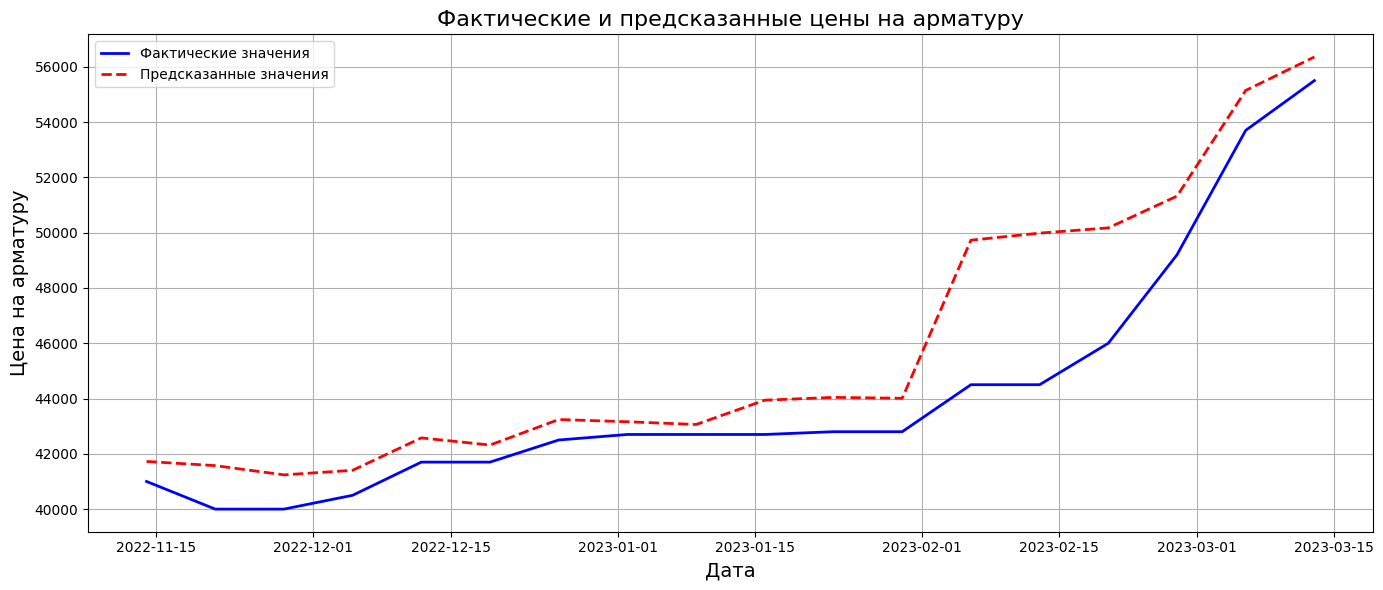

In [199]:
# Прогноз на тестовых данных
X_test = test_data.drop(columns=['dt', 'Цена на арматуру'])
y_pred = xgb_model.predict(X_test)

# Сохраняем фактические и предсказанные значения
test_data['Forecast'] = y_pred

# Визуализация фактических и предсказанных значений
plt.figure(figsize=(14, 6))

# График фактических значений
plt.plot(test_data['dt'], test_data['Цена на арматуру'], label='Фактические значения', color='blue', linewidth=2)

# График предсказанных значений
plt.plot(test_data['dt'], test_data['Forecast'], label='Предсказанные значения', color='red', linestyle='--', linewidth=2)

# Настройки графика
plt.title('Фактические и предсказанные цены на арматуру', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена на арматуру', fontsize=14)
plt.legend()
plt.grid(True)

# Отображаем график
plt.tight_layout()
plt.show()

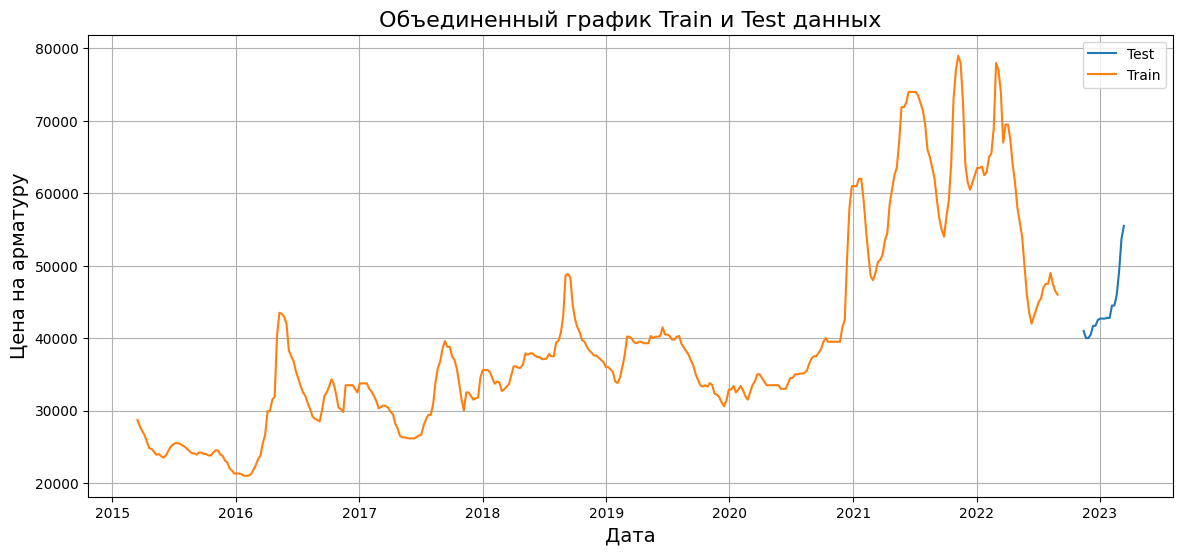

In [200]:
# Объединяем train и test для визуализации
train_data['dataset'] = 'Train'
test_data['dataset'] = 'Test'
combined_data = pd.concat([train_data, test_data])

# Визуализация
plt.figure(figsize=(14, 6))
for label, df in combined_data.groupby('dataset'):
    plt.plot(df['dt'], df['Цена на арматуру'], label=label)

# Настройки графика
plt.title('Объединенный график Train и Test данных', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена на арматуру', fontsize=14)
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()